In [1]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

data = pd.read_csv("data.csv")

data = data[data['balance'] > 0]

data = data[(data['age'] <= 120) & (data['age'] >= 10)]

data.drop(columns=['contact', 'month', 'poutcome', 'default', 'day'], inplace=True)

missing_values = data.isnull().sum()
print("\nMissing values:")
print(missing_values)

categorical_features = ['job', 'marital', 'education', 'housing', 'loan']
numerical_features = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']

data[categorical_features] = data[categorical_features].astype('category')

encoder = OneHotEncoder(sparse=False)
data_encoded = encoder.fit_transform(data[categorical_features])

data_encoded_df = pd.DataFrame(data_encoded, columns=encoder.get_feature_names_out(categorical_features))
data_processed = pd.concat([data_encoded_df, data[numerical_features]], axis=1)

print("\nData types after classification and encoding:\n", data_processed.dtypes)

print("\nShape of the processed dataset:", data_processed.shape)


Missing values:
Id           0
age          0
job          0
marital      0
education    0
balance      0
housing      0
loan         0
duration     0
campaign     0
pdays        0
previous     0
y            0
dtype: int64

Data types after classification and encoding:
 job_admin.             float64
job_blue-collar        float64
job_entrepreneur       float64
job_housemaid          float64
job_management         float64
job_retired            float64
job_self-employed      float64
job_services           float64
job_student            float64
job_technician         float64
job_unemployed         float64
job_unknown            float64
marital_divorced       float64
marital_married        float64
marital_single         float64
education_primary      float64
education_secondary    float64
education_tertiary     float64
education_unknown      float64
housing_no             float64
housing_yes            float64
loan_no                float64
loan_yes               float64
age           

/Users/mohammadhosseinnarang/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [2]:
import numpy as np

class DecisionTree:
    def __init__(self, max_depth=None, min_samples_split=2, criterion='entropy'):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.criterion = criterion
        self.tree = None

    def _calculate_entropy(self, y):
        _, counts = np.unique(y, return_counts=True)
        probabilities = counts / len(y)
        entropy = -np.sum(probabilities * np.log2(probabilities))
        return entropy

    def _find_best_split(self, X, y):
        best_split = None
        best_info_gain = -float('inf')

        for feature in range(X.shape[1]):
            values = np.unique(X[:, feature])
            for value in values:
                left_indices = np.where(X[:, feature] == value)
                right_indices = np.where(X[:, feature] != value)
                left_y = y[left_indices]
                right_y = y[right_indices]

                info_gain = self._calculate_information_gain(y, left_y, right_y)
                if info_gain > best_info_gain:
                    best_split = (feature, value)
                    best_info_gain = info_gain

        return best_split

    def _calculate_information_gain(self, y, left_y, right_y):
        parent_entropy = self._calculate_entropy(y)
        left_entropy = (len(left_y) / len(y)) * self._calculate_entropy(left_y)
        right_entropy = (len(right_y) / len(y)) * self._calculate_entropy(right_y)
        information_gain = parent_entropy - (left_entropy + right_entropy)
        return information_gain

    def _build_tree(self, X, y, depth):
        if len(np.unique(y)) == 1 or depth == self.max_depth or len(y) < self.min_samples_split:
            leaf_node = {'value': np.argmax(np.bincount(y)), 'type': 'leaf'}
            return leaf_node

        best_split = self._find_best_split(X, y)
        if best_split is None:
            leaf_node = {'value': np.argmax(np.bincount(y)), 'type': 'leaf'}
            return leaf_node

        feature, value = best_split
        left_indices = np.where(X[:, feature] == value)
        right_indices = np.where(X[:, feature] != value)
        left_X, left_y = X[left_indices], y[left_indices]
        right_X, right_y = X[right_indices], y[right_indices]

        left_subtree = self._build_tree(left_X, left_y, depth + 1)
        right_subtree = self._build_tree(right_X, right_y, depth + 1)

        decision_node = {'feature': feature, 'value': value, 'left': left_subtree, 'right': right_subtree, 'type': 'decision'}
        return decision_node

    def fit(self, X, y):
        self.tree = self._build_tree(X, y, depth=0)

    def _predict_sample(self, sample, node):
        if node['type'] == 'leaf':
            return node['value']
        elif sample[node['feature']] == node['value']:
            return self._predict_sample(sample, node['left'])
        else:
            return self._predict_sample(sample, node['right'])

    def predict(self, X):
        if self.tree is None:
            raise Exception("Decision tree not fitted yet.")
        predictions = [self._predict_sample(sample, self.tree) for sample in X]
        return np.array(predictions)


In [3]:
data_shuffled = data.sample(frac=1, random_state=42)

split_index = int(0.9 * len(data_shuffled))

train_data = data_shuffled[:split_index]
test_data = data_shuffled[split_index:]

X_train = train_data.drop(columns=['y'])
y_train = train_data['y']

X_test = test_data.drop(columns=['y'])
y_test = test_data['y']



In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

categorical_features = ['job', 'marital', 'education', 'housing', 'loan']

numerical_features = ['age', 'balance']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

decision_tree = DecisionTreeClassifier()

cv_scores = cross_val_score(decision_tree, X_train_processed, y_train, cv=5)

decision_tree.fit(X_train_processed, y_train)

y_pred = decision_tree.predict(X_test_processed)

accuracy = accuracy_score(y_test, y_pred)

print("Cross-validation scores:", cv_scores)
print("Mean Cross-validation accuracy:", np.mean(cv_scores))
print("Accuracy on test set:", accuracy)

# Check if accuracy is at least 70%
if accuracy >= 0.7:
    print("Model meets the minimum accuracy requirement.")
else:
    print("Model does not meet the minimum accuracy requirement.")


Cross-validation scores: [0.81423967 0.8220041  0.81494505 0.81728938 0.81406593]
Mean Cross-validation accuracy: 0.8165088280212804
Accuracy on test set: 0.8241033755274262
Model meets the minimum accuracy requirement.


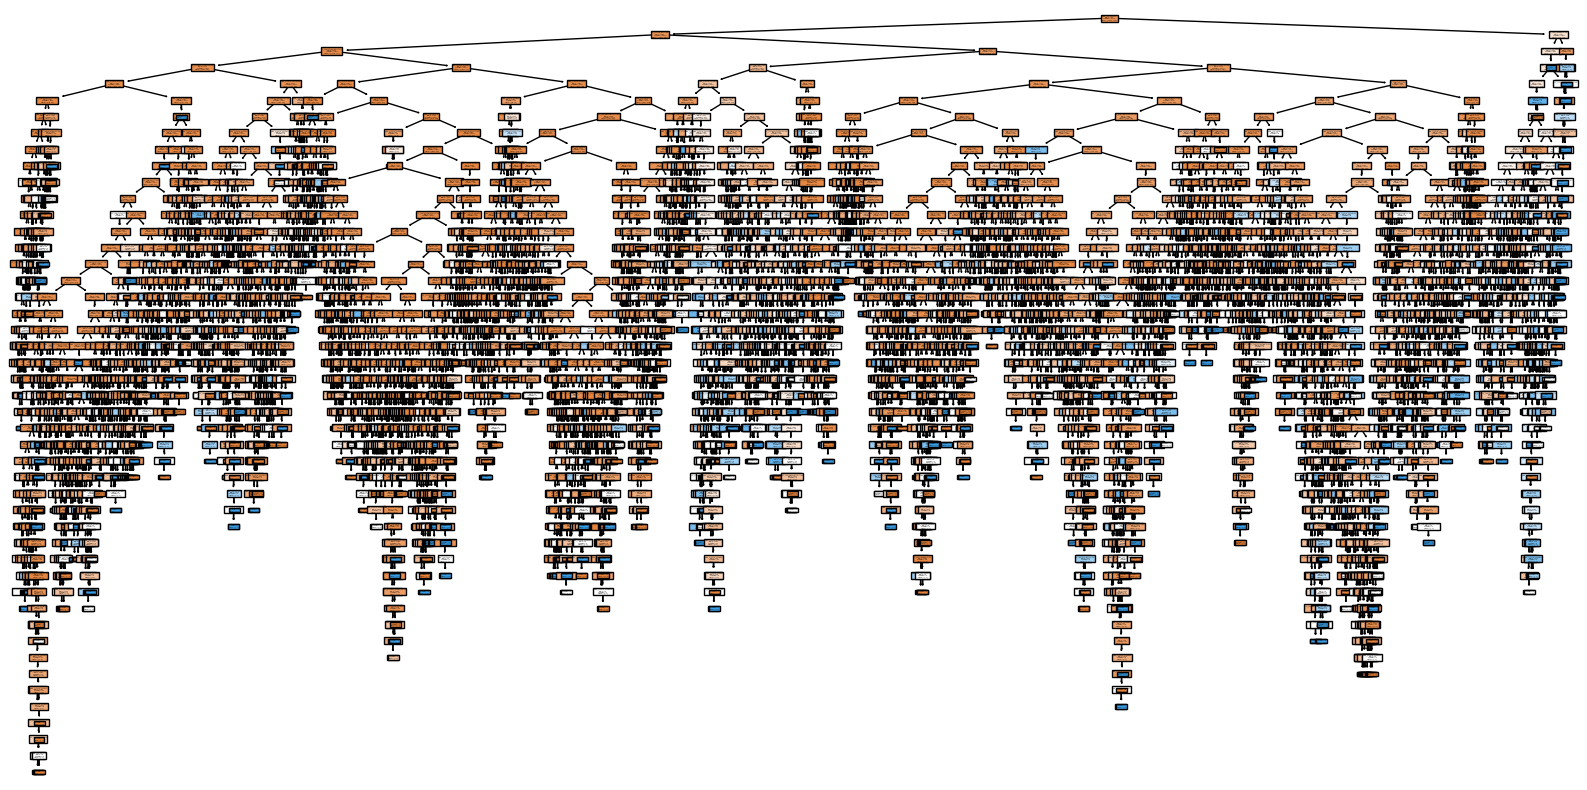

In [7]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Display the decision tree
plt.figure(figsize=(20,10))
plot_tree(decision_tree, filled=True, feature_names=preprocessor.get_feature_names_out())
plt.show()


In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

decision_tree_entropy = DecisionTreeClassifier(criterion='entropy', random_state=42)
decision_tree_entropy.fit(X_train_processed, y_train)

decision_tree_gini = DecisionTreeClassifier(criterion='gini', random_state=42)
decision_tree_gini.fit(X_train_processed, y_train)

y_pred_entropy = decision_tree_entropy.predict(X_test_processed)
y_pred_gini = decision_tree_gini.predict(X_test_processed)

accuracy_entropy = accuracy_score(y_test, y_pred_entropy)
accuracy_gini = accuracy_score(y_test, y_pred_gini)

print("Accuracy with entropy criterion:", accuracy_entropy)
print("Accuracy with Gini index criterion:", accuracy_gini)


Accuracy with entropy criterion: 0.832542194092827
Accuracy with Gini index criterion: 0.8241033755274262
